In [1]:
import fitsio as ft
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
from astropy.table import Table

In [3]:
%matplotlib inline

In [4]:
lens = ft.read('/fs/ess/PHS0336/data/templates/ebv_lhd.hpx.fits')['EBV']
r = hp.Rotator(coord=['G', 'C'])
dust_lens = r.rotate_map_pixel(lens)

mud15 = np.load('/fs/ess/PHS0336/data/tanveer/Mudur_fw15_NSIDE1024_eq_ELG_mask.npy')
mud6 = np.load('/fs/ess/PHS0336/data/tanveer/Mudur_fw6-1_NSIDE1024_eq_ELG_mask.npy')
sagm = np.load('/fs/ess/PHS0336/data/tanveer/SgrStream_Ramos_NSIDE1024_eq_ELG_mask.npy')
hpix_sag = np.argwhere(sagm > 0.5).flatten()

In [5]:
for r in ['bmzls', 'ndecals', 'sdecals']:

    data = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v6/nelg_features_{r}_1024.fits')
    features = []
    for i, col_i in enumerate(data['features'].T):
        features.append(col_i)
    for col_i in [dust_lens[data['hpix']], mud15[data['hpix']], mud6[data['hpix']]]:
        features.append(col_i)
    features = np.array(features).T

    is_good  = (np.isnan(features).sum(axis=1) == 0) 
    is_good &= ((features == hp.UNSEEN).sum(axis=1)==0)
    is_good &= np.in1d(data['hpix'], hpix_sag)

    meta_data = Table(dict(hpix=data['hpix'][is_good],
                     fracgood=data['fracgood'][is_good],
                     features=features[is_good],
                     label=data['label'][is_good]))

    print(r, len(meta_data)/len(data))
    meta_data.write(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v7/nelg_features_{r}_1024.fits', 
                    format='fits', overwrite=True)

bmzls 0.813398969767272
ndecals 0.6441915400054767
sdecals 0.45737934926594503


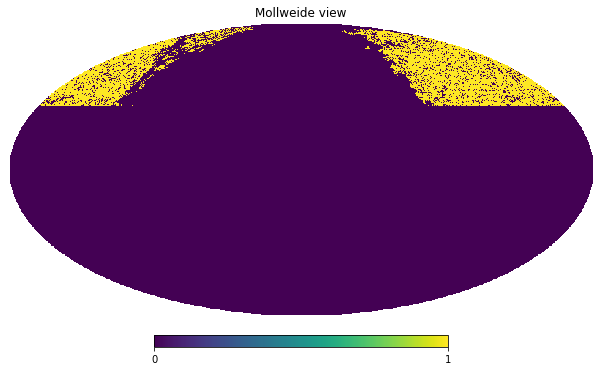

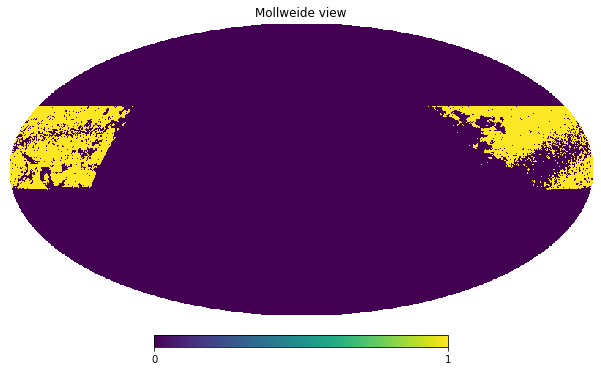

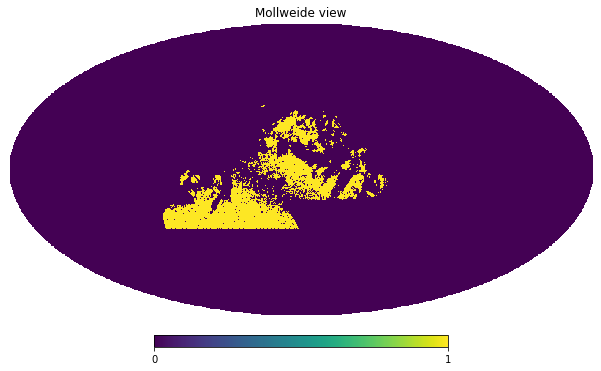

In [12]:
for r in ['bmzls', 'ndecals', 'sdecals']:
    data = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v7/nelg_features_{r}_1024.fits')
    map_ = np.zeros(12*1024*1024)
    map_[data['hpix']] = 1.0
    hp.mollview(map_)